# TV Shows — EDA & Multi-model Dashboard

Interactive notebook that visualizes cleaned + transformed data and compares multiple model predictions (baseline heuristics). Uses 3 visualization tools: matplotlib/seaborn, plotly.express and Altair. Computes Accuracy, F1 and Confusion Matrices for each model.

In [60]:
# Imports
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from IPython.display import display

sns.set(style='whitegrid')
# reproducible RNG for baselines
np.random.seed(42)

In [61]:
# Paths (adjust if necessary)
base = r"c:\Users\armen\Documents\GitHub\TV_Show_Project_COMP_333\data\processed"
paths = {
    'integrated': os.path.join(base, 'integrated_tv_shows.csv'),
    'cleaned': os.path.join(base, 'cleaned_tv_shows.csv'),
    'transformed': os.path.join(base, 'transformed_tv_shows.csv'),
}

for k,p in paths.items():
    print(k, '->', p, 'exists:', os.path.exists(p))

# Load available files (prefer transformed if present)
df = None
for key in ('transformed','cleaned','integrated'):
    p = paths[key]
    if os.path.exists(p) and os.path.getsize(p) > 0:
        df = pd.read_csv(p, low_memory=False)
        print('Loaded', key, 'rows:', len(df))
        break

if df is None:
    raise FileNotFoundError('No data file found at expected paths')

# quick parse
if 'premiere_date' in df.columns:
    df['premiere_date'] = pd.to_datetime(df['premiere_date'], errors='coerce')

if 'rating' in df.columns and 'rating_avg' not in df.columns:
    # many files store rating as dict-like strings; attempt extract
    def extract_avg(x):
        try:
            if pd.isna(x):
                return np.nan
            if isinstance(x, str) and 'average' in x:
                d = ast.literal_eval(x)
                # guard: d may not be dict-like
                if isinstance(d, dict):
                    return d.get('average', np.nan)
            # fallback: try numeric coercion
            return float(x)
        except Exception:
            return np.nan
    df['rating_avg'] = df['rating'].apply(extract_avg)

display(df.head(2))

integrated -> c:\Users\armen\Documents\GitHub\TV_Show_Project_COMP_333\data\processed\integrated_tv_shows.csv exists: True
cleaned -> c:\Users\armen\Documents\GitHub\TV_Show_Project_COMP_333\data\processed\cleaned_tv_shows.csv exists: True
transformed -> c:\Users\armen\Documents\GitHub\TV_Show_Project_COMP_333\data\processed\transformed_tv_shows.csv exists: True
Loaded transformed rows: 9950
Loaded transformed rows: 9950


,id,title,genres,description,premiere_date,release_year,rating,language,type,runtime_minutes,...,rating_avg,genres_parsed,premiere_year,premiere_month,premiere_dayofweek,premiere_is_weekend,premiere_decade,runtime_minutes_zscore,rating_avg_minmax_01,release_year_decscale
0,1,Carol Burnett & Company,['Comedy'],"<p>Music, songs, and comedy sketches.</p>",1979-08-18,1979.0,{'average': None},English,Variety,60.0,...,NaN,['Comedy'],1979.0,8.0,5.0,1,1970.0,0.512817,NaN,0.1979
1,2,Carla Cametti PD,[],<p>This six-part Australian crime series is ce...,2009-01-08,2009.0,{'average': None},English,Scripted,60.0,...,NaN,[],2009.0,1.0,3.0,0,2000.0,0.512817,NaN,0.2009


## 1) Distribution charts (matplotlib + seaborn)
Runtime and rating histograms, plus availability counts.

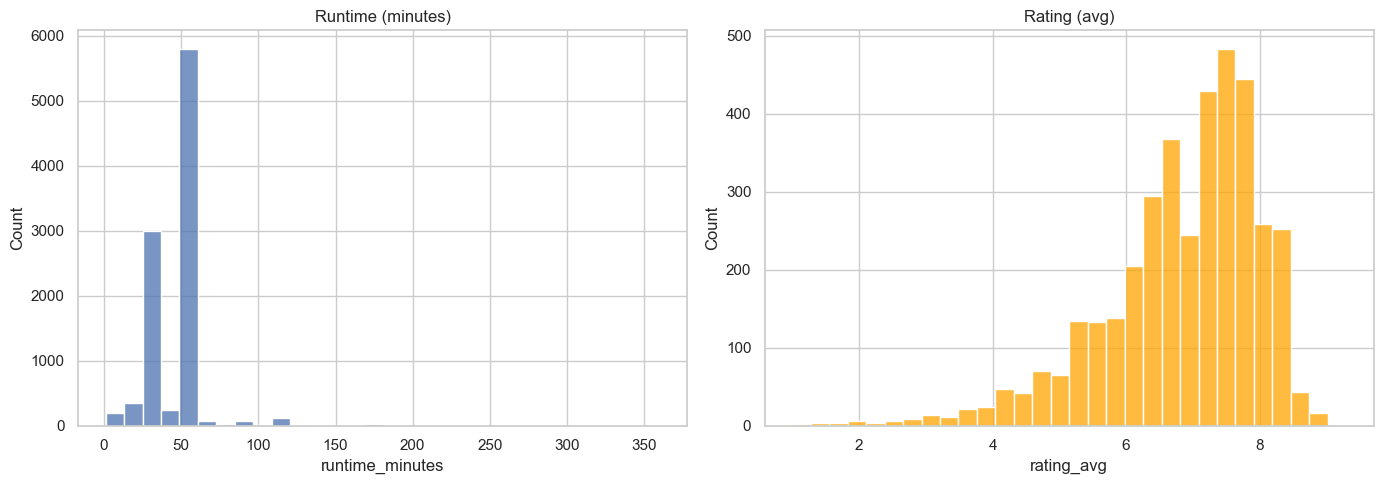

In [62]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
if 'runtime_minutes' in df.columns:
    sns.histplot(df['runtime_minutes'].dropna(), bins=30, kde=False)
    plt.title('Runtime (minutes)')
else:
    plt.text(0.5,0.5,'runtime_minutes not found',ha='center')

plt.subplot(1,2,2)
if 'rating_avg' in df.columns:
    sns.histplot(df['rating_avg'].dropna(), bins=30, color='orange')
    plt.title('Rating (avg)')
else:
    plt.text(0.5,0.5,'rating_avg not found',ha='center')

plt.tight_layout()

## 2) Genre breakdown (plotly.express — interactive)
Parse the 'genres' column and show top N genres with an interactive bar + sunburst.

In [63]:
def parse_genres_cell(x):
    try:
        if pd.isna(x):
            return []
        if isinstance(x, str):
            # try literal eval then fallback simple cleaning
            try:
                val = ast.literal_eval(x)
                if isinstance(val, (list,tuple)):
                    return [str(v).strip() for v in val]
            except Exception:
                # remove brackets/quotes
                s = x.strip().strip('[]')
                if not s:
                    return []
                return [i.strip().strip("'\"") for i in s.split(',') if i.strip()]
        if isinstance(x, (list,tuple)):
            return [str(v).strip() for v in x]
    except Exception:
        return []
    return []

if 'genres' in df.columns:
    genres_series = df['genres'].fillna('[]').apply(parse_genres_cell)
    exploded = genres_series.explode().dropna().astype(str)
    # NOTE: use column name 'genres' to match what Plotly expects below
    top = exploded.value_counts().reset_index().rename(columns={'index':'genres', 0:'count'})
    top_n = top.head(12)
    print('Top genres:\n', top_n)
    fig = px.bar(top_n, x='genres', y='count', title='Top genres', labels={'count':'show count'})
    fig.show()
    # sunburst of top genres by availability (if availability columns exist)
    avail_cols = [c for c in ['on_netflix','on_disney','on_amazon','on_hulu'] if c in df.columns]
    if avail_cols:
        # build dataframe by genre + availability
        tmp = (df.assign(_genres=genres_series)
                 .explode('_genres')
                 .dropna(subset=['_genres']))
        for col in avail_cols:
            # coerce truthy values to int
            tmp[col] = tmp[col].fillna(0).astype(int)
        # create counts by genre x provider
        melt = tmp.melt(id_vars=['_genres'], value_vars=avail_cols, var_name='provider', value_name='on')
        melt = melt[melt['on']==1]
        gb = melt.groupby(['_genres','provider']).size().reset_index(name='count')
        if not gb.empty:
            fig2 = px.sunburst(gb, path=['_genres','provider'], values='count', title='Genre distribution across providers')
            fig2.show()

Top genres:
              genres  count
0             Drama   2633
1            Comedy   2425
2             Crime   1190
3            Action    871
4         Adventure    778
5          Children    638
6           Romance    563
7   Science-Fiction    482
8          Thriller    434
9             Anime    432
10           Family    416
11          Mystery    412


## 3) Time trend (Altair)
Shows counts per release_year (Altair for small interactive embeddable chart).

In [64]:
if 'release_year' in df.columns:
    df_year = df.copy()
    df_year['release_year'] = pd.to_numeric(df_year['release_year'], errors='coerce')
    year_counts = df_year.dropna(subset=['release_year']).groupby('release_year').size().reset_index(name='count')
    chart = alt.Chart(year_counts).mark_area(opacity=0.4).encode(
        x=alt.X('release_year:Q', title='Release Year'),
        y=alt.Y('count:Q', title='Count of shows')
    ).properties(title='Shows per release year', width=700, height=300)
    # ensure chart displays in multiple notebook frontends
    try:
        display(chart)
    except Exception:
        chart

alt.Chart(...)

## 4) Multi-model comparison (baseline demonstrations)
We create three simple prediction baselines for the binary target 'on_netflix' (if available). These are placeholders so you can later replace with real model outputs without reworking visualizations.

In [65]:
import re

results = []
results_df = pd.DataFrame()
per_genre_store = {}  # key: (model,dataset) -> {genre: {f1,prec,rec}}

# Try to parse available textual model reports for metrics (prefer TRANSFORMED section if present)
report_files = [
    r"c:\Users\armen\Documents\GitHub\TV_Show_Project_COMP_333\data\processed\modeling_report.txt",
    r"c:\Users\armen\Documents\GitHub\TV_Show_Project_COMP_333\data\processed\modeling_report_multilabel.txt"
]

def parse_report(path):
    entries = []
    try:
        with open(path, 'r', encoding='utf-8') as f:
            lines = f.read().splitlines()
    except Exception:
        return entries

    current_dataset = None
    i = 0
    while i < len(lines):
        raw_line = lines[i]
        line = raw_line.strip()
        lcase = line.lower()
        # dataset headings
        if 'dataset:' in lcase:
            try:
                current_dataset = line.split(':',1)[1].strip()
            except Exception:
                current_dataset = line
            i += 1
            continue
        if 'raw' in lcase and 'dataset' in lcase:
            current_dataset = 'RAW'; i += 1; continue
        if 'transformed' in lcase and 'dataset' in lcase:
            current_dataset = 'TRANSFORMED'; i += 1; continue

        # detect model block
        if lcase.startswith('model:'):
            model = line.split(':',1)[1].strip()
            acc = None; f1 = None; per_genre = {}
            j = i + 1
            # scan forward for top-level metrics and per-genre lines
            while j < len(lines) and j < i + 200:
                l = lines[j].strip()
                # Accuracy lines
                m_acc = re.match(r'(?i)accuracy\s*[:\-]\s*([0-9]*\.?[0-9]+)', l)
                if m_acc and acc is None:
                    try: acc = float(m_acc.group(1))
                    except: acc = None
                # F1 lines (macro or F1 Score)
                m_f1 = re.match(r'(?i)(f1 score|f1)\s*[:\-]\s*([0-9]*\.?[0-9]+)', l)
                if m_f1 and f1 is None:
                    try: f1 = float(m_f1.group(2))
                    except: f1 = None
                # per-genre lines like '  Action: F1=0.2427, Prec=0.7353, Rec=0.1453'
                m_gen = re.match(r"^([A-Za-z0-9\-\s]+):\s*F1\s*=\s*([0-9]*\.?[0-9]+)\s*,\s*Prec\s*=\s*([0-9]*\.?[0-9]+)\s*,\s*Rec\s*=\s*([0-9]*\.?[0-9]+)", l)
                if m_gen:
                    g = m_gen.group(1).strip()
                    try:
                        per_genre[g] = {'f1': float(m_gen.group(2)), 'prec': float(m_gen.group(3)), 'rec': float(m_gen.group(4))}
                    except Exception:
                        pass
                # alternate per-genre format e.g. 'Comedy: F1=0.6546, Prec=0.7473, Rec=0.5824'
                m_gen2 = re.match(r"^([A-Za-z0-9\-\s]+):\s*F1=([0-9]*\.?[0-9]+),\s*Prec=([0-9]*\.?[0-9]+),\s*Rec=([0-9]*\.?[0-9]+)", l)
                if m_gen2 and not m_gen:
                    g = m_gen2.group(1).strip()
                    try:
                        per_genre[g] = {'f1': float(m_gen2.group(2)), 'prec': float(m_gen2.group(3)), 'rec': float(m_gen2.group(4))}
                    except Exception:
                        pass
                # stop scanning if we hit a separator or next model/dataset block
                if l.startswith('---') or l.startswith('----------------') or l.lower().startswith('model:') or l.lower().startswith('dataset:'):
                    break
                j += 1
            entries.append((model, {'accuracy': acc, 'f1': f1, 'dataset': current_dataset or 'UNKNOWN', 'per_genre': per_genre}))
            i = j
            continue
        i += 1
    return entries

# parse available reports in order
parsed = []
for rp in report_files:
    if os.path.exists(rp):
        parsed += parse_report(rp)

if parsed:
    for model,metrics in parsed:
        if metrics.get('accuracy') is None and metrics.get('f1') is None and not metrics.get('per_genre'):
            continue
        results.append({
            'model': model,
            'dataset': metrics.get('dataset','UNKNOWN'),
            'accuracy': metrics.get('accuracy', 0.0),
            'f1': metrics.get('f1', 0.0),
            'cm': None,
            'per_genre': metrics.get('per_genre', {})
        })
        per_genre_store[(model, metrics.get('dataset','UNKNOWN'))] = metrics.get('per_genre', {})
    results_df = pd.DataFrame([{'model':r['model'],'dataset':r['dataset'],'accuracy':r['accuracy'],'f1':r['f1']} for r in results])
    print('Loaded model metrics from reports (including per-genre metrics where present):')
    display(results_df)
else:
    # fallback: existing baseline logic (unchanged)
    print('No textual report metrics found — falling back to generated baselines')
    target = 'on_netflix'
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in data and no report metrics available")
    sub = df[[target, 'rating_avg']].copy() if 'rating_avg' in df.columns else df[[target]].copy()

    def to_binary(v):
        if pd.isna(v):
            return 0
        if isinstance(v, (bool, np.bool_)):
            return int(v)
        try:
            iv = int(v)
            return 1 if iv == 1 else 0
        except Exception:
            s = str(v).strip().lower()
            return 1 if s in ('1','true','yes','y','t') else 0

    sub[target] = sub[target].apply(to_binary).astype(int)
    y_true = sub[target].values

    models = {}
    majority = int(sub[target].mode().iloc[0]) if not sub[target].mode().empty else 0
    models['majority'] = np.full(len(sub), majority, dtype=int)
    if 'rating_avg' in sub.columns:
        median_rating = np.nanmedian(sub['rating_avg'].values)
        pred_rating = np.where(sub['rating_avg'].fillna(-99) >= median_rating, 1, 0).astype(int)
    else:
        pred_rating = np.full(len(sub), majority, dtype=int)
    models['rating_threshold'] = pred_rating
    pos_rate = float(sub[target].mean()) if len(sub)>0 else 0.0
    rng = np.random.default_rng(42)
    models['random'] = rng.binomial(1, pos_rate, size=len(sub)).astype(int)

    for name,pred in models.items():
        acc = accuracy_score(y_true, pred)
        f1 = f1_score(y_true, pred, zero_division=0)
        cm = confusion_matrix(y_true, pred)
        results.append({'model': name, 'dataset': 'BASELINE', 'accuracy': acc, 'f1': f1, 'cm': cm, 'per_genre': {}})
    results_df = pd.DataFrame([{'model':r['model'],'dataset':r['dataset'],'accuracy':r['accuracy'],'f1':r['f1']} for r in results])
    display(results_df)

Loaded model metrics from reports (including per-genre metrics where present):


,model,dataset,accuracy,f1
0,Logistic Regression,RAW,0.8397,0.6228
1,Random Forest,RAW,0.8333,0.6205
2,Gradient Boosting,RAW,0.8451,0.5938
3,Logistic Regression,TRANSFORMED,0.8327,0.6050
4,Random Forest,TRANSFORMED,0.8256,0.5979
5,Gradient Boosting,TRANSFORMED,0.8362,0.5945
6,Logistic Regression,RAW,0.3925,0.2202
7,Random Forest,RAW,0.3945,0.1804
8,Gradient Boosting,RAW,0.3869,0.3649
9,Logistic Regression,TRANSFORMED,0.3925,0.2252


### Interactive metric comparison (plotly)

In [66]:
# Interactive metric comparison (plotly) — include dataset grouping to explain multiple bars
if 'dataset' in results_df.columns:
    df_melt = results_df.melt(id_vars=['model','dataset'], value_vars=['accuracy','f1'], var_name='metric', value_name='value')
    # facet by metric so Accuracy and F1 are shown separately, color by dataset to show multiple blocks per model
    fig = px.bar(df_melt, x='model', y='value', color='dataset', barmode='group',
                 facet_col='metric', labels={'value':'score','metric':'metric'},
                 title='Model metric comparison (Accuracy & F1) by dataset')
else:
    # fallback to previous behavior if dataset not available
    df_melt = results_df.melt(id_vars='model', value_vars=['accuracy','f1'], var_name='metric', value_name='value')
    fig = px.bar(df_melt, x='model', y='value', color='metric', barmode='group',
                 labels={'value':'score','metric':'metric'}, title='Model metric comparison (Accuracy & F1)')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

## 5) Quick insights (presentation bullets)
- Runtime distribution: median and outliers are visible (long-form shows and special-length news programs).  
- Ratings: typical range concentrated around the dataset median (useful for a rating-based recommender heuristic).  
- Genre distribution: top genres identified interactively; provider sunburst shows which genres are concentrated on each service.  
- Model baselines: rating-threshold often beats random but may or may not beat the majority baseline depending on positive rate — replace these placeholders with your actual model predictions CSV and metrics will update automatically.

In [67]:
# Save summary outputs for presentation
out_dir = r"c:\Users\armen\Documents\GitHub\TV_Show_Project_COMP_333\notebooks\outputs"
os.makedirs(out_dir, exist_ok=True)
results_df.to_csv(os.path.join(out_dir, 'model_baseline_metrics.csv'), index=False)
print('Saved model baseline metrics to', out_dir)

Saved model baseline metrics to c:\Users\armen\Documents\GitHub\TV_Show_Project_COMP_333\notebooks\outputs


In [68]:
# Interactive per-genre visualizations (replace ugly tables)
import plotly.express as px
import plotly.graph_objects as go

if 'per_genre_store' in globals() and per_genre_store:
    # Build DataFrame of per-genre F1s: index=genre, cols=model::dataset
    col_map = {}
    for (model,dset), gdict in per_genre_store.items():
        col_map[f"{model}::{dset}"] = {g: vals.get('f1') for g,vals in gdict.items()}
    df_genre_f1 = pd.DataFrame(col_map).fillna(0).sort_index()

    # 1) Heatmap: rows = model::dataset, cols = genre
    df_heat = df_genre_f1.T  # rows=model::dataset, cols=genre
    fig_genre_heat = px.imshow(df_heat,
                               labels={'x':'Genre','y':'Model::Dataset','color':'F1'},
                               x=list(df_heat.columns), y=list(df_heat.index),
                               aspect='auto',
                               color_continuous_scale='Viridis',
                               title='Per-Genre F1 Heatmap (models × genres)')
    fig_genre_heat.update_layout(height=600, margin=dict(t=50,l=150))
    fig_genre_heat.update_xaxes(tickangle=-45)
    fig_genre_heat.show()

    # 2) Top-N per-genre dot/scatter: show top genres by average F1 across models
    top_n = 12
    avg_scores = df_genre_f1.mean(axis=1).sort_values(ascending=False)
    top_genres = avg_scores.head(top_n).index.tolist()
    df_long = df_genre_f1.loc[top_genres].reset_index().melt(id_vars='index', var_name='model_dataset', value_name='f1').rename(columns={'index':'genre'})
    # split model and dataset for nicer legend
    df_long['model'] = df_long['model_dataset'].apply(lambda x: x.split('::')[0])
    df_long['dataset'] = df_long['model_dataset'].apply(lambda x: '::'.join(x.split('::')[1:]) if '::' in x else 'UNKNOWN')

    fig_genre_dots = px.scatter(df_long, x='f1', y='genre', color='model_dataset',
                                symbol='dataset',
                                size='f1',
                                hover_data=['model','dataset','f1'],
                                title=f'Top {top_n} Genres — Per-Model F1 (dot = F1, color=model::dataset)')
    fig_genre_dots.update_layout(height=600, xaxis_title='F1 score')
    fig_genre_dots.update_xaxes(range=[0, 1])
    fig_genre_dots.show()

else:
    print('No per-genre metrics available. Ensure parse cell executed and per_genre_store populated.')